In [1]:
import os
import pandas as pd
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Hyndman-Khandakar algorithm
1. Determine d using repeated stationarity tests.
2. choose p and q, by minimizing the AICcs.

In [2]:
warnings.filterwarnings("ignore")

def hyndman_khandakar_non_seasonal_forecast(time_series: pd.Series, dif : int, p: int, q: int):

    print(f"Arima (Hyndman-Khandakar logic)")
    
    model = pm.auto_arima(
        y = time_series,
        start_p = 1, start_q = 1,
        max_p = p, max_q = q,
        seasonal = False,
        maxiter = 18,
        d = dif,
        test = "kpss",
        stepwise = True,
        trace = False,
        error_action = 'trace',
        suppress_warnings = True,
        information_criterion = 'aicc'
    )

    print(f"\nBest Model")
    print(model.summary())
    print("-" * 40)
    print(f"Selected ARIMA Order: {model.order}")

    return model


In [3]:
def forecasting_HK(model, h):
    forecasts = model.predict(h)
    
    if isinstance(time_series, pd.Series):
        try:
            last_date = time_series.index[-1]
            if isinstance(last_date, pd.Timestamp):
                 # For datetime index
                freq = time_series.index.freq if time_series.index.freq is not None else pd.infer_freq(time_series.index)
                forecast_index = pd.date_range(start=last_date, periods=h + 1, freq=freq)[1:]
            else:
                 # For a simple integer index
                forecast_index = pd.RangeIndex(start=len(time_series), stop=len(time_series) + h)
        except Exception:
            forecast_index = pd.RangeIndex(start=len(time_series), stop=len(time_series) + h)


    forecast_series = pd.Series(forecasts, index=forecast_index, name='Forecast')
    print(f"forecast series : {forecast_series}")
    return forecast_series


In [4]:
def cast_to_time(df):
    df['time'] = pd.to_datetime(df['time'])
    return df

In [5]:
data_dir = '../Data/Preprocessed'
base_paths = os.listdir(data_dir)
full_paths = [os.path.join(data_dir, p) for p in base_paths]
patients = {base_paths[i].split('.')[0] : cast_to_time(pd.read_csv(fp, sep=';')) for i, fp in enumerate(full_paths)}
ids = list(patients.keys())
s = 1

In [6]:
too_long = ["HUPA0027P", "HUPA0028P", "HUPA0026P"]
for i in too_long:
    ids.remove(i)

## no differentiation, d = 0

In [7]:
results_d0 = []

for i in ids:
    d = 0
    ts = patients[i].loc[:, "glucose"]
    print(f"longitud : {len(ts)}")
    print(f"paciente : {i}")
    # Run the non-seasonal HK algorithm
    result = hyndman_khandakar_non_seasonal_forecast(time_series = ts, dif = d, p = 7, q = 7)
    results_d0.append(result)
    time.sleep(s)


longitud : 3895
paciente : HUPA0018P
Arima (Hyndman-Khandakar logic)

Best Model
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3895
Model:               SARIMAX(5, 0, 6)   Log Likelihood               -8462.932
Date:                Tue, 07 Oct 2025   AIC                          16949.865
Time:                        20:52:57   BIC                          17025.074
Sample:                             0   HQIC                         16976.561
                               - 3895                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9319      0.141     13.657      0.000       1.655       2.209
ar.L2         -0.9150      0.302     -3.031      0

## Differentiation = 1

In [8]:
results_d1 = []

for i in ids:
    d = 1
    ts = patients[i].loc[:, "glucose"]
    print(f"longitud : {len(ts)}")
    print(f"paciente : {i}")
    # Run the non-seasonal HK algorithm
    result = hyndman_khandakar_non_seasonal_forecast(time_series = ts, dif = d, p = 5, q = 5)
    results_d1.append(result)
    time.sleep(s)


longitud : 3895
paciente : HUPA0018P
Arima (Hyndman-Khandakar logic)

Best Model
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3895
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -8473.822
Date:                Tue, 07 Oct 2025   AIC                          16959.644
Time:                        21:10:22   BIC                          16997.247
Sample:                             0   HQIC                         16972.991
                               - 3895                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0343      0.058     -0.591      0.554      -0.148       0.079
ar.L2          0.0039      0.075      0.052      0

## Hyperparameter Analysis

In [9]:
def hyperparameters(results_dn):
    d_p = []
    d_q = []
    for r_dn in results_dn:
        p = r_dn.order[0]
        q = r_dn.order[2]
        d_p.append(p)
        d_q.append(q)
    return d_p, d_q

In [10]:
d0_p, d0_q = hyperparameters(results_d0)
d1_p, d1_q = hyperparameters(results_d1)

In [ ]:
l = len(d0_p)
zeros = [0 for i in range(l)]
ones = [1 for i in range(l)]

In [18]:
pd_0 = pd.DataFrame({
    "p" : d0_p,
    "q" : d0_q,
    "type" : zeros
})

pd_1 = pd.DataFrame({
    "p" : d1_p,
    "q" : d1_q,
    "type" : ones
})

coefficients = pd.concat([pd_0, pd_1])

[]

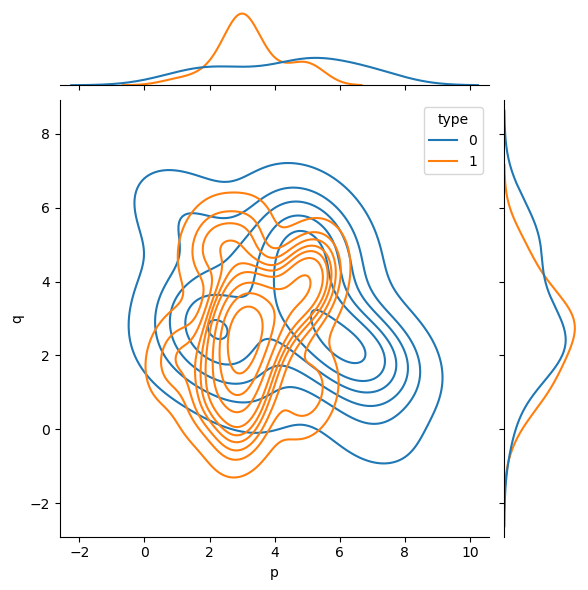

In [ ]:
sns.jointplot(
    data = coefficients,
    x = "p",
    y = "q",
    hue = "type",
    kind = "kde"
    )
plt.plot()